In [2]:
# Dependencies:
# cargo install tokei
# pip install seaborn

# Inspired by https://kylekizirian.github.io/git-tokei.html

In [1]:
import json
import subprocess
import seaborn as sns
import pandas as pd
import re
from pathlib import Path
from glob import glob

In [13]:
sns.set(rc={ 'figure.figsize': (15, 12) })
sns.set(font_scale=1.5)

## Kernel Directories

In [14]:
def loc_plot(directory, n=None):

    dirs_lines = []
    directories = glob(str(directory) + "/*/", recursive=True)

    if n is None:
        n = len(directories)

    for directory in directories:
        tokei = subprocess.run(
            ["tokei", directory, "--output", "json"],
            stdout=subprocess.PIPE,
            encoding="utf-8"
        )
        tokei_json = json.loads(tokei.stdout)
        lines = tokei_json["Total"]["code"]
        dirs_lines.append(lines)

    d = { 'Directories': list(map(lambda d : Path(d).stem, directories)), 'Lines': dirs_lines }
    df = pd.DataFrame(d, columns=['Directories', 'Lines'])

    ax = sns.barplot(
        x='Lines',
        y='Directories',
        data=df,
        order=df.sort_values('Lines', ascending=False).Directories.head(n)
    )

In [15]:
# Top-level Linux directories
linux_repo = Path.home() / "Documents" / "linux-tcc/linux"
loc_plot(linux_repo)

In [32]:
# Top 10 directories under linux/driver/ in numbers of lines
loc_plot(linux_repo / 'drivers', 10)

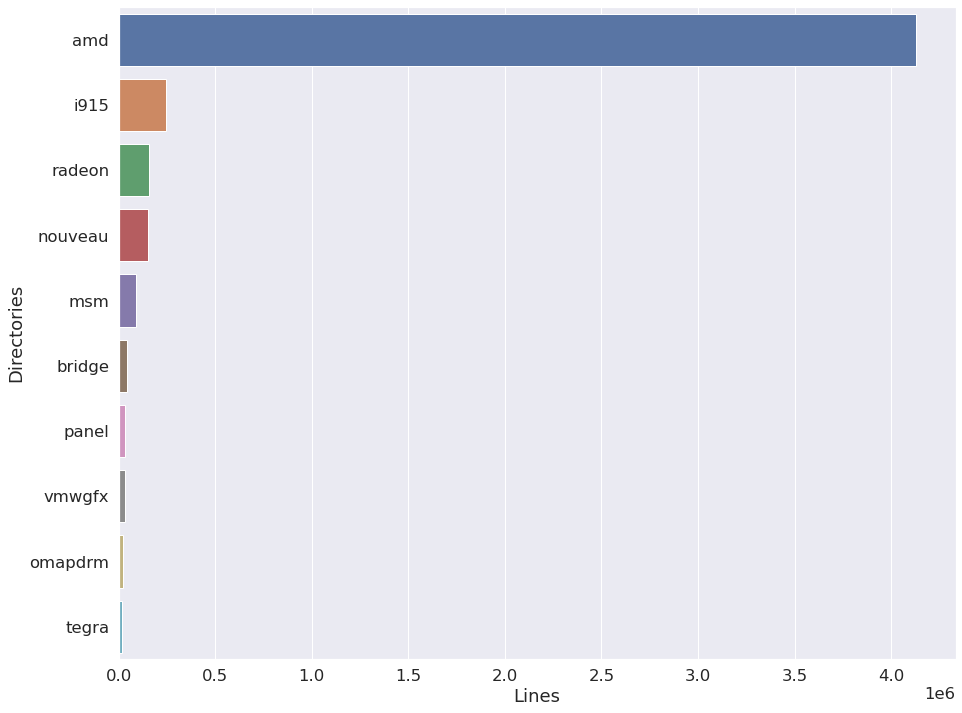

In [33]:
# Top 10 directories under linux/driver/gpu/drm in numbers of lines
loc_plot(linux_repo / 'drivers' / 'gpu' / 'drm', 10)

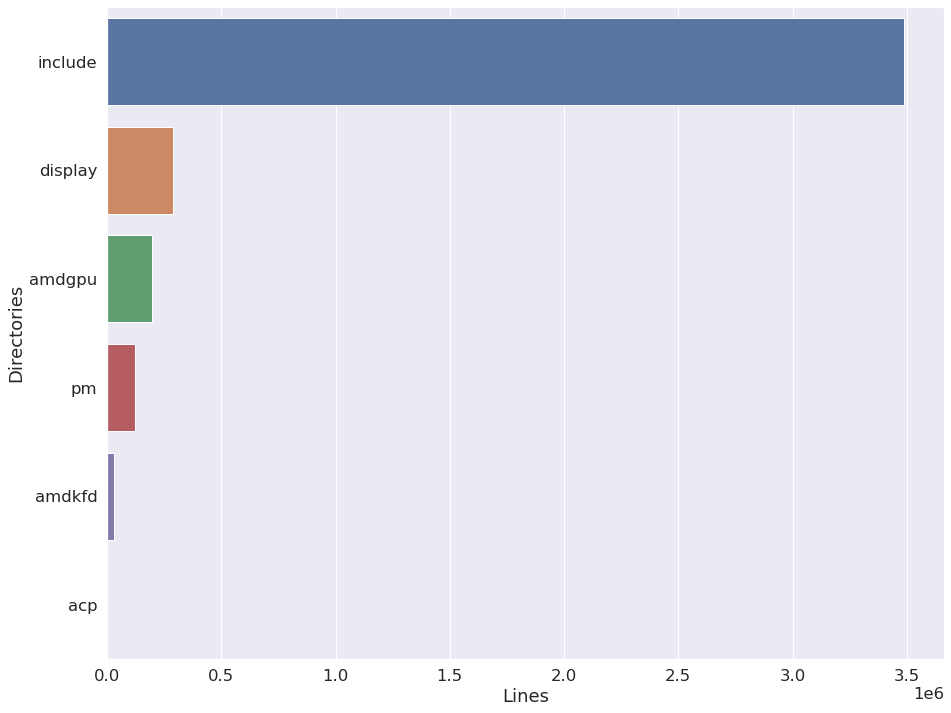

In [34]:
# Top directories under linux/driver/gpu/drm/amd in numbers of lines
loc_plot(linux_repo / 'drivers' / 'gpu' / 'drm' / 'amd')

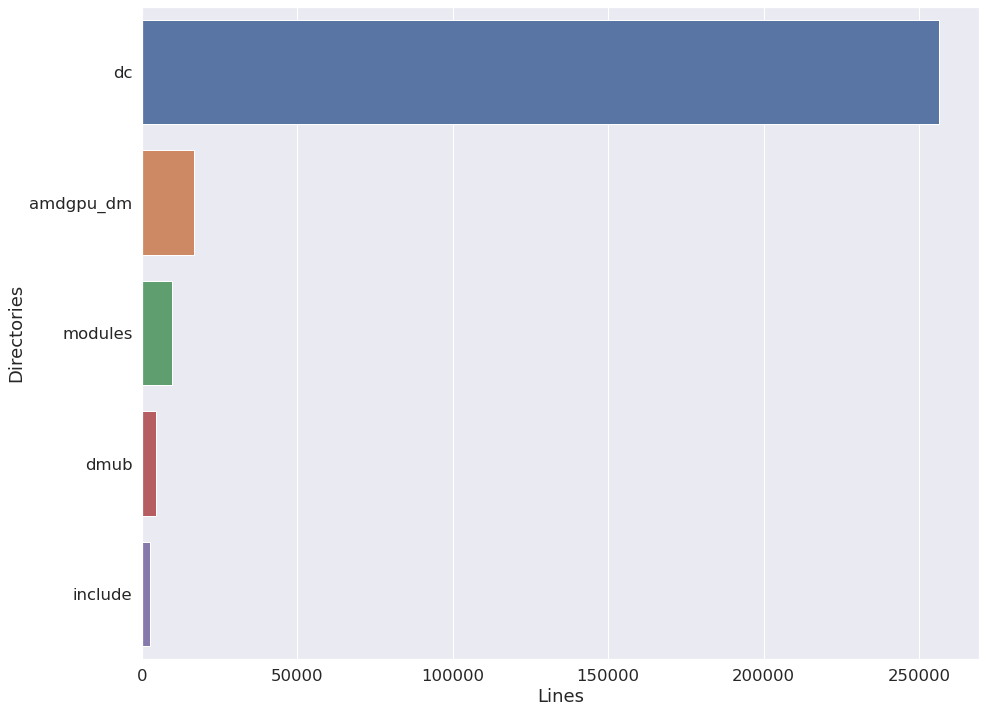

In [35]:
# Top directories under linux/driver/gpu/drm/amd/display in numbers of lines
loc_plot(linux_repo / 'drivers' / 'gpu' / 'drm' / 'amd' / 'display')

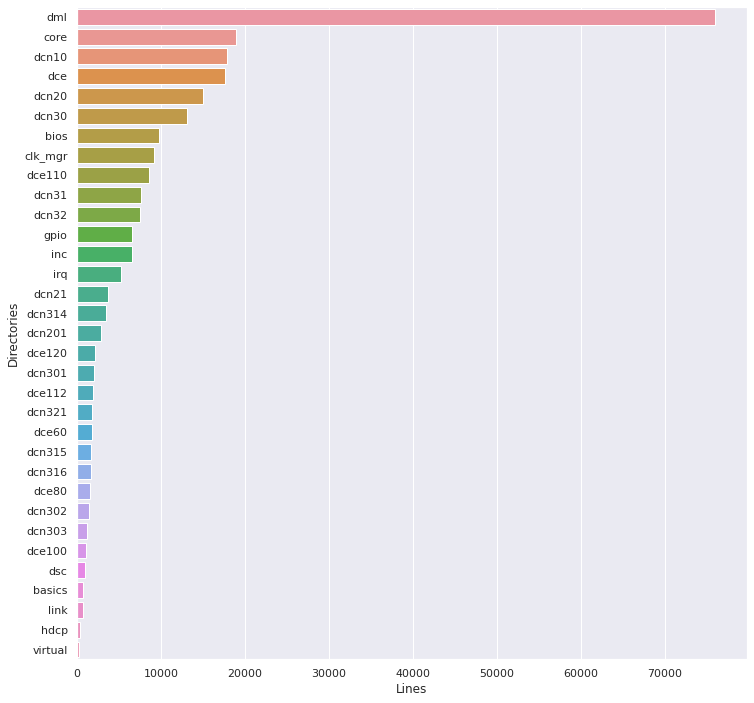

In [14]:
# Top directories under linux/driver/gpu/drm/amd/display in numbers of lines
sns.set(font_scale=1)
loc_plot(linux_repo / 'drivers' / 'gpu' / 'drm' / 'amd' / 'display' / 'dc')

## KUnit's Usage

In [51]:
"""
    Evaluate the number of subsystems that use KUnit.
    To write unit tests using KUnit, the first thing to do is adding the
    library that contains KUnit's API.
    From this premise, to estimate the number of subsystems that use KUnit,
    look for all files that include "kunit/test.h".
    For each file that meets this requirement, run the get_maintainer script
    to retrieve the name of the subsystem that is responsible for that file.
    
    Use a regular expression to obtain the first line from the script's
    output, which corresponds to the subsystem that is responsible for that
    file.
    Regex: [^\n]+: any character except a newline
"""

subsystems_kunit = set()

paths = Path(linux_repo).rglob('*')
for path in paths:
    if path.is_file():
        with open(path, 'r', encoding="ISO-8859-1") as f:
                if "kunit/test.h" in f.read():
                    maintainer = subprocess.run(
                        ["./scripts/get_maintainer.pl", "--subsystem", "--no-email", "--no-l", path],
                        stdout=subprocess.PIPE,
                        cwd=linux_repo,
                        encoding="utf-8")
                    if "qos" in str(path):
                        print(maintainer.stdout)
                    subsystem = re.match("[^\n]+", maintainer.stdout).group(0)
#                     print(subsystem + "  " + str(path))
                    
                    subsystems_kunit.add(subsystem)


./scripts/get_maintainer.pl: file '/home/magali/Documents/linux-tcc/linux/.git/index' doesn't appear to be a patch.  Add -f to options?


POWER MANAGEMENT CORE
HIBERNATION (aka Software Suspend, aka swsusp)
SUSPEND TO RAM
DRIVER CORE, KOBJECTS, DEBUGFS AND SYSFS
THE REST



In [12]:
len(subsystems_kunit)

35

In [52]:
subsystems_kunit

{'APPARMOR SECURITY MODULE',
 'ASPEED SD/MMC DRIVER',
 'BITMAP API',
 'CHROME HARDWARE PLATFORM SUPPORT',
 'COMMON CLK FRAMEWORK',
 'DATA ACCESS MONITOR',
 'DRIVER CORE, KOBJECTS, DEBUGFS AND SYSFS',
 'DRM DRIVERS',
 'EXT4 FILE SYSTEM',
 'FILESYSTEMS (VFS and infrastructure)',
 'GENERIC INCLUDE/ASM HEADER FILES',
 'HID CORE LAYER',
 'IIO SUBSYSTEM AND DRIVERS',
 'KASAN',
 'KCSAN',
 'KERNEL UNIT TESTING FRAMEWORK (KUnit)',
 'KFENCE',
 'KPROBES',
 'LANDLOCK SECURITY MODULE',
 'LINEAR RANGES HELPERS',
 'LIST KUNIT TEST',
 'MANAGEMENT COMPONENT TRANSPORT PROTOCOL (MCTP)',
 'NETWORKING [GENERAL]',
 'NETWORKING [MPTCP]',
 'NITRO ENCLAVES (NE)',
 'POWER MANAGEMENT CORE',
 'PROC SYSCTL',
 'REAL TIME CLOCK (RTC) SUBSYSTEM',
 'S390',
 'SLAB ALLOCATOR',
 'SOUND - SOC LAYER / DYNAMIC AUDIO POWER MANAGEMENT (ASoC)',
 'THE REST',
 'THUNDERBOLT DRIVER',
 'TIMEKEEPING, CLOCKSOURCE CORE, NTP, ALARMTIMER',
 'VFAT/FAT/MSDOS FILESYSTEM'}

In [16]:
"""
    Evaluate the number of subsystem in the kernel based on MAINTAINERS.
    Subsystems in the kernel are listed in the MAINTAINERS file like so:

    THE REST
    M:	Linus Torvalds <torvalds@linux-foundation.org>
    L:	linux-kernel@vger.kernel.org
    S:	Buried alive in reporters
    T:	git git://git.kernel.org/pub/scm/linux/kernel/git/torvalds/linux.git
    F:	*
    F:	*/

    The first line (THE REST) is the name of subsystem, the other lines are
    section entries, listing information such as the mailing list email, the
    maintainers, tree, status, etc.

    To estimate the number of subsystems, look for a pattern as described
    below:

    Regex: (?<=^\n)        asserts that what precedes the subsystem name is a newline only
            .+             subsystem name, composed of at least one character
           (?=\n[A-Z]:)    asserts that what follows the subsystem name is a newline followed by a section entry
"""

subsystems = set()

maintainers_path = linux_repo / 'MAINTAINERS'
with open(maintainers_path, 'r', encoding="ISO-8859-1") as f:
    subsystem = re.findall("(?<=^\n).+(?=\n[A-Z]:)", f.read(), re.MULTILINE) 

In [17]:
len(subsystem)

2586

# WIP

In [57]:
linux_tags = subprocess.run(
    [
        "git", "tag", "--list", 'v[5-9].[0-9]*',
        "--sort=version:refname"
    ],
    cwd=linux_repo,
    stdout=subprocess.PIPE,
    encoding="utf-8",
)
tags = []

for t in linux_tags.stdout.split("\n")[:-1]:
    final = re.match("v[0-9].[0-9]*$", t)
    if final is not None:
        tags.append(final.group(0))

In [62]:
def subsystems_with_kunit():
    subsystems_kunit = set()

    paths = Path(linux_repo).rglob('*')
    for path in paths:
        if path.is_file():
            with open(path, 'r', encoding="ISO-8859-1") as f:
                    if "kunit/test.h" in f.read():
                        maintainer = subprocess.run(
                            ["./scripts/get_maintainer.pl", "--subsystem", "--no-email", "--no-l", path],
                            stdout=subprocess.PIPE,
                            cwd=linux_repo,
                            encoding="utf-8")
                        subsystem = re.match("[^\n]+", maintainer.stdout).group(0)

                        subsystems_kunit.add(subsystem)
    return subsystems_kunit

In [63]:
kunit_usage = []

for tag in tags[4:]:
    subprocess.run(
        ["git", "checkout", tag],
        cwd=linux_repo,
        encoding="utf-8",
    )
    kunit_usage.append(len(subsystems_with_kunit()))

Previous HEAD position was e93c9c99a629 Linux 5.1
HEAD is now at 219d54332a09 Linux 5.4
Previous HEAD position was 219d54332a09 Linux 5.4
HEAD is now at d5226fa6dbae Linux 5.5
./scripts/get_maintainer.pl: file '/home/magali/Documents/linux-tcc/linux/.git/index' doesn't appear to be a patch.  Add -f to options?
Previous HEAD position was d5226fa6dbae Linux 5.5
HEAD is now at 7111951b8d49 Linux 5.6
./scripts/get_maintainer.pl: file '/home/magali/Documents/linux-tcc/linux/.git/index' doesn't appear to be a patch.  Add -f to options?
Previous HEAD position was 7111951b8d49 Linux 5.6
HEAD is now at 3d77e6a8804a Linux 5.7
./scripts/get_maintainer.pl: file '/home/magali/Documents/linux-tcc/linux/.git/index' doesn't appear to be a patch.  Add -f to options?
Previous HEAD position was 3d77e6a8804a Linux 5.7
HEAD is now at bcf876870b95 Linux 5.8
./scripts/get_maintainer.pl: file '/home/magali/Documents/linux-tcc/linux/.git/index' doesn't appear to be a patch.  Add -f to options?
Previous HEAD po

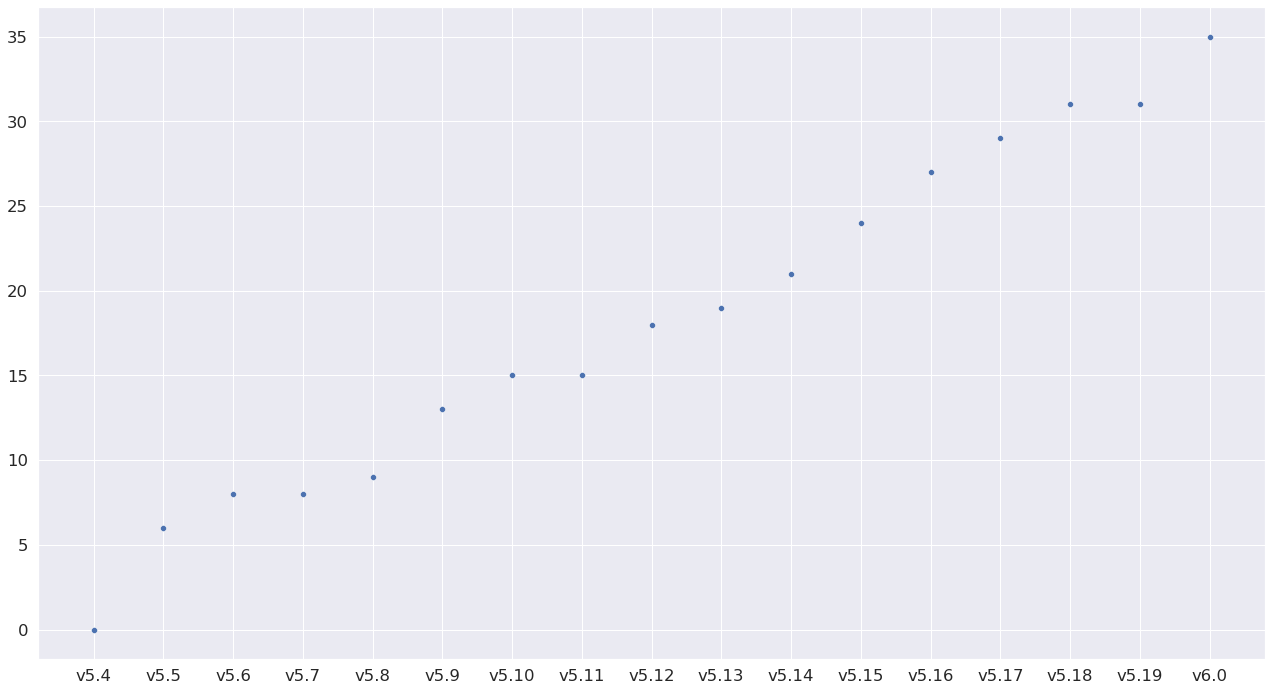

In [65]:
plt = sns.scatterplot(x=tags[4:], y=kunit_usage)

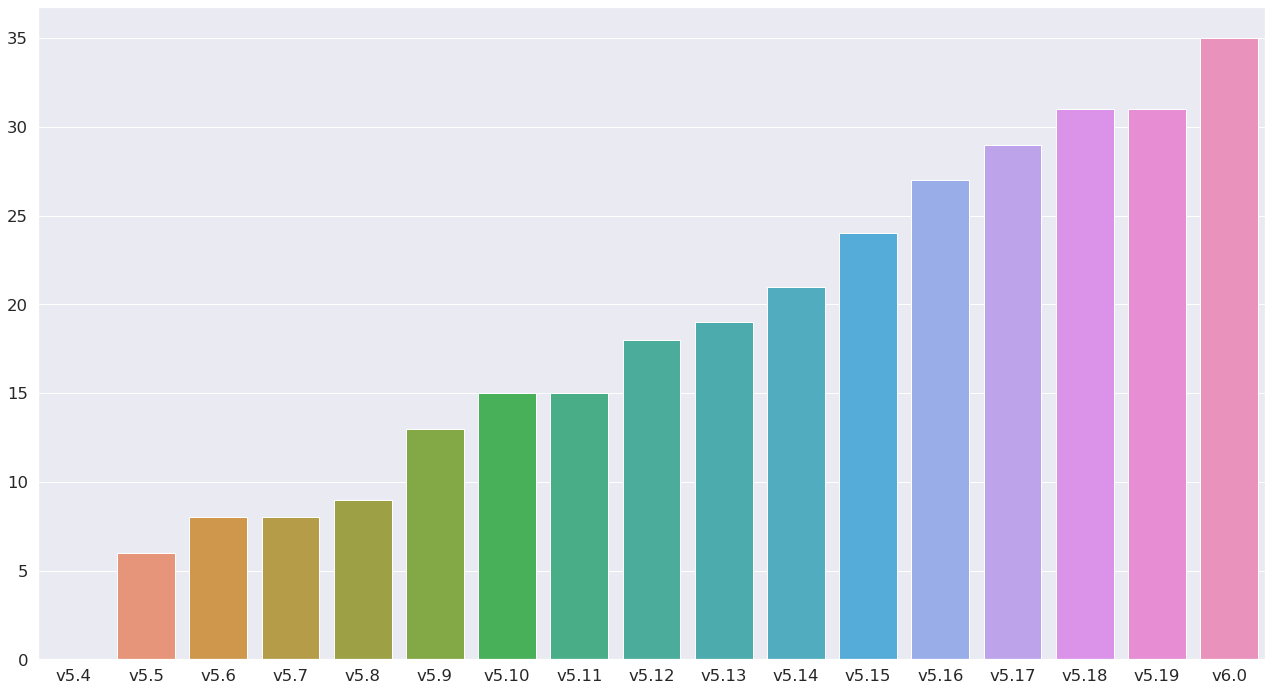

In [66]:
plt = sns.barplot(x=tags[4:], y=kunit_usage)

In [67]:
sns.set(rc={ 'figure.figsize': (22, 12) })
sns.set(font_scale=1.5)


Text(0, 0.5, 'Number of subsystems')

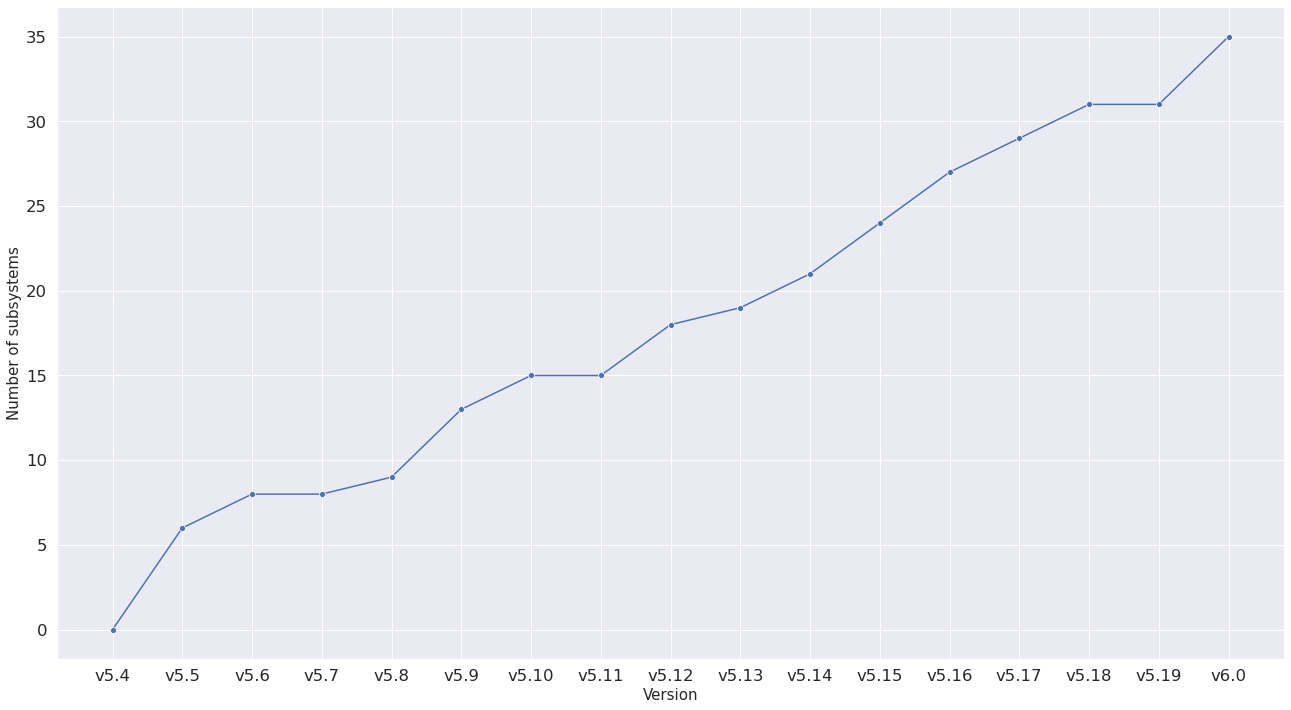

In [69]:
plt = sns.lineplot(x=tags[4:], y=kunit_usage, marker='o')
plt.set_xlabel("Version", fontsize=15)
plt.set_ylabel("Number of subsystems", fontsize=15)


In [110]:
paths = Path(linux_repo).rglob('*')
for path in paths:
    print(Path(path).stem)

.git
.cocciconfig
Documentation
LICENSES
README
arch
block
certs
crypto
drivers
fs
include
init
ipc
kernel
lib
mm
net
samples
scripts
security
sound
tools
usr
virt
.gitattributes
COPYING
Kbuild
Kconfig
.gitignore
.clang-format
.get_maintainer
.mailmap
CREDITS
MAINTAINERS
Makefile
io_uring
branches
hooks
info
description
refs
objects
packed-refs
logs
config
ORIG_HEAD
index
HEAD
applypatch-msg
commit-msg
post-update
pre-applypatch
pre-commit
pre-merge-commit
pre-push
pre-receive
push-to-checkout
update
fsmonitor-watchman
pre-rebase
prepare-commit-msg
exclude
heads
tags
remotes
master
origin
HEAD
pack
info
pack-aea5952e3573e7a43c1f9b7fcf0ce301de4f692a
pack-aea5952e3573e7a43c1f9b7fcf0ce301de4f692a
refs
HEAD
remotes
heads
origin
HEAD
master
ABI
Changes
CodingStyle
RCU
SubmittingPatches
admin-guide
arm
bpf
core-api
crypto
dev-tools
devicetree
doc-guide
driver-api
fb
features
filesystems
firmware_class
gpu
input
kbuild
kernel-hacking
maintainer
misc-devices
netlabel
networking
process
s390
sc

qcom,cpr
4xx
fsl
ibm,powerpc-cpu-features
ibm,vas
nintendo
opal
sleep
akebono
cpm
hsta
ppc440spe-adma
reboot
ccf
dcsr
diu
dma
ecm
interlaken-lac
lbc
mcm
mcu-mpc8349emitx
mpc5121-psc
mpc512x_lpbfifo
mpic-msgr
mpic-timer
mpic
msi-pic
pamu
pmc
raideng
scfg
srio-rmu
srio
l2cache
cpus
mpc5200
gamecube
wii
oppanel-opal
sensor-groups
power-mgt
pps-gpio
brcm,ptp-dte
ptp-ines
timestamper
ptp-idt82p33
ptp-qoriq
ptp-idtcm
cirrus,clps711x-pwm
lpc32xx-pwm
pwm-st
pwm-tipwmss
pxa-pwm
atmel-hlcdc-pwm
brcm,kona-pwm
img-pwm
lpc1850-sct-pwm
nxp,pca9685-pwm
pwm-bcm2835
pwm-berlin
pwm-fsl-ftm
pwm-hibvt
pwm-lp3943
pwm-meson
pwm-sprd
pwm
spear-pwm
st,stmpe-pwm
ti,twl-pwm
ti,twl-pwmled
vt8500-pwm
nvidia,tegra20-pwm
kontron,sl28cpld-pwm
brcm,iproc-pwm
pwm
allwinner,sun4i-a10-pwm
brcm,bcm7038-pwm
imx-pwm
imx-tpm-pwm
intel,keembay-pwm
intel,lgm-pwm
iqs620a-pwm
microchip,corepwm
mxs-pwm
pwm-rockchip
pwm-samsung
pwm-sifive
pwm-tiecap
pwm-tiehrpwm
renesas,pwm-rcar
renesas,tpu-pwm
toshiba,pwm-visconti
atmel,at91sam-

common
mpp
mv2120-setup
ts78xx-fpga
tsx09-common
Makefile
board-mss2
terastation_pro2-setup
ts209-setup
ts409-setup
tsx09-common
dns323-setup
Kconfig
board-d2net
board-dt
board-rd88f5182
bridge-regs
common
db88f5281-setup
irq
irqs
kurobox_pro-setup
ls_hgl-setup
mpp
net2big-setup
orion5x
pci
rd88f5181l-fxo-setup
rd88f5181l-ge-setup
rd88f5182-setup
rd88f6183ap-ge-setup
ts78xx-setup
wnr854t-setup
wrt350n-v2-setup
Makefile
headsmp
platsmp
Kconfig
csb701
devices
littleton
mfp-pxa25x
mfp-pxa27x
mioa701
mxm8x10
pm
pxa300
pxa320
pxa930
udc
capc7117
eseries-irq
h5000
himalaya
lpd270
mfp-pxa300
mfp-pxa320
mfp-pxa930
mioa701_bootresume
mp900
palm27x
palmte2
palmtreo
palmz72
pcm027
pm
saar
sharpsl_pm
tosa-bt
tosa_bt
viper
zeus
am200epd
tavorevb
pxa_cplds_irqs
Makefile
addr-map
am300epd
balloon3-pcmcia
balloon3
balloon3
cm-x300
colibri-evalboard
colibri-pcmcia
colibri-pxa270-income
colibri-pxa270
colibri-pxa300
colibri-pxa320
colibri-pxa3xx
colibri
corgi
corgi
corgi_pm
csb726
csb726
devices
e740-pc

clocksource
processor
vsyscall
data
gettimeofday
asm
auxvec
bitsperlong
byteorder
chpid
chsc
clp
cmb
guarded_storage
hypfs
ioctls
kvm_para
kvm_perf
monwriter
perf_regs
qeth
sclp_ctl
sigcontext
stat
statfs
sthyi
tape390
types
ucontext
unistd
virtio-ccw
vmcp
vtoc
termios
Kbuild
posix_types
bpf_perf_event
dasd
runtime_instr
ipcbuf
ipl
sie
ptrace
schid
setup
signal
pkey
uvdevice
zcrypt
hwctrset
kvm
audit
compat_ptrace
ebcdic
guarded_storage
syscalls
vdso64
compat_linux
kdebugfs
ima_arch
reipl
kexec_elf
kexec_image
.gitignore
machine_kexec_reloc
trace
runtime_instr
early_printk
kprobes_insn_page
perf_regs
fpu
idle
sthyi
vdso32
debug
ipl_vmparm
audit
compat_audit
cpcmd
nospec-sysfs
syscall
dis
dumpstack
perf_cpum_cf_common
perf_cpum_sf
cache
compat_signal
diag
ftrace
head64
ipl
kprobes
lgr
mcount
nospec-branch
numa
os_info
ptrace
signal
smp
stacktrace
sysinfo
text_amode31
topology
traps
unwind_bc
uprobes
vtime
alternative
asm-offsets
compat_linux
early
earlypgm
entry
entry
ftrace
irq
machine

smuio_v9_0
soc15_common
soc21
uvd_v5_0
uvd_v6_0
uvd_v7_0
vce_v3_0
vce_v4_0
vcn_sw_ring
vcn_sw_ring
vcn_v2_0
vcn_v2_5
vcn_v2_5
vcn_v3_0
vcn_v4_0
vi
Kconfig
Makefile
aldebaran
amdgpu
amdgpu_acp
amdgpu_acpi
amdgpu_amdkfd
amdgpu_amdkfd
amdgpu_amdkfd_fence
amdgpu_amdkfd_gpuvm
amdgpu_atomfirmware
amdgpu_cs
amdgpu_ctx
amdgpu_debugfs
amdgpu_device
amdgpu_discovery
amdgpu_display
amdgpu_display
amdgpu_drv
amdgpu_fence
amdgpu_fru_eeprom
amdgpu_gfx
amdgpu_gfx
amdgpu_ih
amdgpu_imu
amdgpu_job
amdgpu_job
amdgpu_kms
amdgpu_mes
amdgpu_mes
amdgpu_mes_ctx
amdgpu_mode
amdgpu_object
amdgpu_psp
amdgpu_psp
amdgpu_ras
amdgpu_ras
amdgpu_res_cursor
amdgpu_reset
amdgpu_reset
amdgpu_ring
amdgpu_ring
amdgpu_rlc
amdgpu_rlc
amdgpu_ttm
amdgpu_ttm
amdgpu_ucode
amdgpu_ucode
amdgpu_umc
amdgpu_vcn
amdgpu_vcn
amdgpu_virt
amdgpu_vkms
amdgpu_vm
amdgpu_vram_mgr
amdgpu_vram_mgr
amdgpu_xgmi
athub_v3_0
atombios_encoders
clearstate_gfx11
dce_v10_0
dce_v11_0
dce_v6_0
dce_v8_0
gfx_v10_0
gfx_v11_0
gfx_v9_0
gfxhub_v3_0
gmc_v10_0
gm

Makefile
siw_cm
siw_cq
Kconfig
iwarp
siw_mem
siw_mem
siw_qp
siw_verbs
siw
siw_qp_rx
siw_main
siw_cm
siw_qp_tx
siw_verbs
ipoib
iser
isert
opa_vnic
srp
srpt
Makefile
rtrs
Makefile
Kconfig
ipoib_fs
ipoib_multicast
ipoib_ethtool
ipoib_cm
ipoib_netlink
ipoib_vlan
ipoib
ipoib_verbs
ipoib_ib
ipoib_main
Makefile
Kconfig
iser_memory
iscsi_iser
iscsi_iser
iser_initiator
iser_verbs
Makefile
Kconfig
ib_isert
ib_isert
opa_vnic_encap
opa_vnic_ethtool
opa_vnic_internal
opa_vnic_encap
opa_vnic_vema_iface
Kconfig
Makefile
opa_vnic_vema
opa_vnic_netdev
Kbuild
Kconfig
ib_srp
ib_srp
ib_dm_mad
Makefile
Kconfig
ib_srpt
ib_srpt
Kconfig
Makefile
README
rtrs-log
rtrs
rtrs-clt-sysfs
rtrs-clt
rtrs
rtrs-clt-stats
rtrs-clt
rtrs-pri
rtrs-srv-stats
rtrs-srv-sysfs
rtrs-srv
rtrs-srv
gameport
joystick
keyboard
misc
mouse
rmi4
serio
tablet
touchscreen
apm-power
input-compat
input-compat
input-leds
mousedev
ff-memless
input-poller
matrix-keymap
sparse-keymap
evdev
input-poller
evbug
touchscreen
joydev
ff-core
Kconfig
Mak

sdk
cmd
cmd
conn
sdk
conn
core
core
ipoib
ipoib_vlan
ethtool
ipoib
port_tun
geneve
geneve
pci_vsc
pci_vsc
hv
hv
hv_vhca
vxlan
crypto
fs_chains
gid
mlx5
mpfs
mpfs
clock
eq
sf
clock
fs_ttc
fs_chains
fs_ttc
hv_vhca
port_tun
smfs
smfs
vxlan
devcom
devcom
aso
aso
dm
tout
tout
Makefile
fs_dr
dr_buddy
mlx5_ifc_dr_ste_v1
dr_dbg
dr_domain
dr_fw
dr_icm_pool
dr_matcher
dr_rule
dr_send
dr_ste
dr_ste
dr_ste_v0
dr_ste_v1
dr_ste_v2
dr_action
dr_cmd
dr_dbg
dr_ste_v1
dr_table
dr_types
fs_dr
mlx5_ifc_dr
mlx5dr
Makefile
acl
indir_table
legacy
vporttbl
diag
bridge_priv
qos
qos
indir_table
legacy
bridge
bridge
debugfs
devlink_port
lgcy
helper
helper
egress_lgcy
egress_ofld
ingress_lgcy
ingress_ofld
ofld
qos_tracepoint
bridge_tracepoint
cmd
dev
mlx5_ifc_vhca_event
vhca_event
priv
sf
diag
vhca_event
hw_table
devlink
dev
diag
driver
dev
dev_tracepoint
sf_tracepoint
vhca_tracepoint
mp
debugfs
lag
mp
mpesw
mpesw
port_sel
port_sel
lag
mlxfw_mfa2
mlxfw_mfa2_file
mlxfw_mfa2_format
mlxfw_mfa2_tlv_multi
mlxfw_mfa2_t

cedrus
Kconfig
Makefile
TODO
cedrus_dec
cedrus_video
Makefile
Kconfig
cedrus_hw
cedrus_hw
cedrus
cedrus
cedrus_dec
cedrus_h264
cedrus_h265
cedrus_mpeg2
cedrus_regs
cedrus_video
cedrus_vp8
ipu3-css-params
ipu3-css-pool
ipu3-dmamap
ipu3-tables
ipu3-mmu
ipu3-tables
Makefile
TODO
ipu3-dmamap
ipu3-mmu
include
ipu3-abi
ipu3-css-pool
ipu3-css
ipu3-css
ipu3
Kconfig
ipu3-css-fw
ipu3-css-fw
ipu3-css-params
ipu3-v4l2
ipu3
uapi
intel-ipu3
hantro_vp8
hantro_g1
hantro_g1_mpeg2_dec
hantro_mpeg2
rockchip_vpu2_hw_mpeg2_dec
rockchip_vpu2_regs
rockchip_vpu2_hw_vp8_dec
hantro_g1_regs
hantro_g1_vp8_dec
Makefile
hantro_g2
hantro_vp9
hantro_vp9
Kconfig
hantro_h1_jpeg_enc
hantro_h1_regs
hantro_jpeg
hantro_jpeg
rockchip_vpu2_hw_jpeg_enc
TODO
hantro_g1_h264_dec
hantro_h264
rockchip_vpu2_hw_h264_dec
hantro
hantro_drv
hantro_g2_hevc_dec
hantro_g2_regs
hantro_g2_vp9_dec
hantro_hevc
hantro_hw
hantro_postproc
hantro_v4l2
hantro_v4l2
imx8m_vpu_hw
rockchip_vpu_hw
sama5d4_vdec_hw
sunxi_vpu_hw
vdec
TODO
codec_mpeg12
cod

kprobes
ksm
kthread
latencytop
linkage
list
livepatch
lockref
lsm_audit
mailbox_controller
mdio
mei_aux
memregion
mhi_ep
mm_inline
mman
mod_devicetable
mount
namei
nfs4
nfs_fs_sb
notifier
nvme-fc-driver
nvmem-consumer
of_irq
omap-dma
oom
page-isolation
phylink
platform_device
pm
pm_domain
pm_runtime
polynomial
prandom
printk
property
ptp_classify
ptp_clock_kernel
ptrace
randomize_kstack
ratelimit_types
reboot
refcount
reset
rpmsg
rtnetlink
rtsx_pci
rtsx_usb
seccomp
seq_file
seqlock
set_memory
signal
siphash
slab
slub_def
srcutree
stackdepot
stackleak
stmmac
stop_machine
string
suspend
swap_slots
sysfb
task_work
tee_drv
thunderbolt
timekeeping
timer
timex
topology
torture
vermagic
vhost_iotlb
vmalloc
wm97xx
acpi
acpi_iort
acpi_viot
amd-iommu
aperture
arch_topology
atm_tcp
audit
backing-dev-defs
backing-dev
balloon_compaction
base64
bio
bitmap
bitops
blk-mq
blk_types
blkdev
blktrace_api
bpf-cgroup-defs
bpf-cgroup
bpf
bpf_lsm
bpf_verifier
bpfptr
brcmphy
btf
btf_ids
buffer_head
cacheinfo
c

Makefile
dwc-pcm
local
Kconfig
dwc-i2s
fsl_esai
imx-audmux
mpc5200_dma
fsl_dma
efika-audio-fabric
fsl_ssi
fsl_audmix
mpc5200_psc_ac97
fsl_asrc
fsl_asrc_common
fsl_ssi_dbg
fsl_aud2htx
fsl_xcvr
Makefile
imx-audio-rpmsg
imx-pcm-rpmsg
fsl_dma
imx-pcm-fiq
imx-pcm-rpmsg
mpc5200_dma
eukrea-tlv320
fsl_rpmsg
imx-rpmsg
mpc8610_hpcd
p1022_ds
p1022_rdk
imx-spdif
fsl_spdif
imx-pcm-dma
imx-es8328
imx-hdmi
imx-pcm
imx-sgtl5000
imx-ssi
Kconfig
fsl-asoc-card
fsl_asrc
fsl_asrc_dma
fsl_aud2htx
fsl_audmix
fsl_easrc
fsl_easrc
fsl_esai
fsl_micfil
fsl_micfil
fsl_mqs
fsl_rpmsg
fsl_sai
fsl_sai
fsl_spdif
fsl_ssi
fsl_utils
fsl_utils
fsl_xcvr
imx-audmix
imx-audmux
imx-card
mpc5200_psc_i2s
pcm030-audio-fabric
Kconfig
Makefile
audio-graph-card2-custom-sample
simple-card
audio-graph-card
audio-graph-card2-custom-sample
audio-graph-card2
simple-card-utils
test-component
Kconfig
Makefile
hi6210-i2s
hi6210-i2s
Makefile
Kconfig
img-i2s-in
img-i2s-out
img-parallel-out
img-spdif-in
img-spdif-out
pistachio-internal-dac
ato

In [7]:
def commits_amount(contributor, linux_repo):

    command_template = "git log --oneline"
    if contributor == "external":
        command_template += " --author='^(?!(.*@amd[.]com))' --perl-regexp"
    elif contributor == "amd":
        command_template += " --author='^(.*@amd[.]com)' --perl-regexp"
    else:
        print("Hm?")

    commits = []

    for year in range(2019, 2023):
        command = command_template
        command += " --after=\"" + str(year) + "-01-01\"" + " --until=\"" + str(year) + "-12-31\""
        command += " -- drivers/gpu/drm/amd/display | wc -l"

        commits_out = subprocess.run(
            command,
            cwd=linux_repo,
            encoding="utf-8",
            shell=True,
            stdout=subprocess.PIPE,
        )

        commits.append(int(commits_out.stdout))

    return {"year": list(range(2019, 2023)),
            "contributor": [contributor]*4,
            "commits": commits}


In [8]:
df1 = pd.DataFrame(commits_amount("amd", linux_repo))
df = df1.append(pd.DataFrame(commits_amount("external", linux_repo)), ignore_index=True)


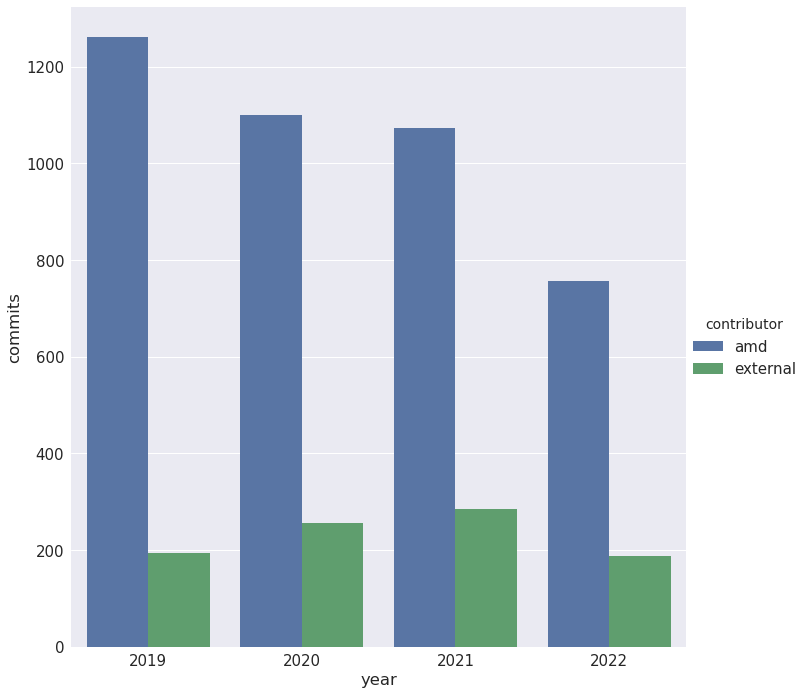

In [22]:
sns.factorplot(x='year', y='commits', hue='contributor', data=df, kind='bar', size=10)
